In [1]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA device count:", torch.cuda.device_count())
    print("Current CUDA device:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. Check your installation.")


PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 5080


In [20]:
import gymnasium as gym


# Use Gymnasium's built-in vectorization
num_envs = 16
env_name = "Pusher-v5"    

# Create vectorized environment using Gymnasium's native support
envs = gym.make_vec(env_name, num_envs=num_envs)
print("Vectorized environment created")

# Reset should now work properly
state = envs.reset()
if isinstance(state, tuple):
    state, info = state
print("State shape:", state.shape)
print("Number of environments:", len(state))


Vectorized environment created
State shape: (16, 23)
Number of environments: 16


In [21]:
use_cuda = torch.cuda.is_available()
print("Using CUDA:", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
print("Device:", device)

Using CUDA: True
Device: cuda


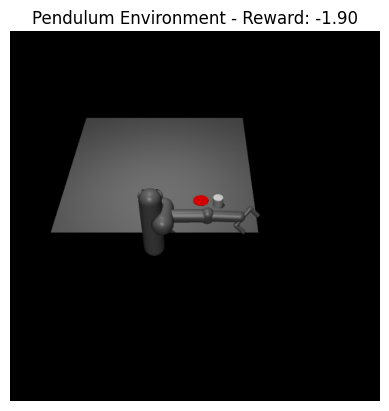

In [22]:
# visualize the environment in the notebook
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Create environment with rgb_array for visualization (no video recording)
env = gym.make(env_name, render_mode='rgb_array')
print("Environment created:", env)

# Reset and get initial observation
obs, info = env.reset()
print("Observation space:", obs.shape)
print("Info:", info)

# Run a random episode and display it in real-time
done = False
start_time = time.time()

# Create figure once
plt.figure(figsize=(8, 6))

while time.time() - start_time < 10:  # Run for 10 seconds
    action = env.action_space.sample()  # Random action
    obs, reward, done, truncated, info = env.step(action)
    
    # Get frame and display it
    frame = env.render()
    
    # Clear previous plot and show new frame
    clear_output(wait=True)
    plt.imshow(frame)
    plt.axis('off')
    plt.title(f'Pendulum Environment - Reward: {reward:.2f}')
    plt.show()
    
    # Reset if episode ends
    if done or truncated:
        obs, info = env.reset()
    
    time.sleep(0.05)  # Small delay to see the animation

In [23]:
env.action_space

Box(-2.0, 2.0, (7,), float32)

In [46]:
# define the neural network
import torch.nn as nn
import torch.nn.functional as F

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        # The critic network estimates the value function
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

        # The actor network 
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs)
        )
        # Initialize log standard deviation, this is used for continuous action spaces
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std) 
        self.apply(initialize_weights)

    def forward(self, x):
        value = self.critic(x)
        mu = self.actor(x)
        std = self.log_std.exp().expand_as(mu)
        dist = torch.distributions.Normal(mu, std)
        return dist, value

In [47]:
def plot(frame_idx, rewards):
    clear_output(wait = True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f'frame {frame_idx}, rewards: {rewards[-1]}')
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

def test_env(vis=False):
    state, info = env.reset()
    if vis:
        frame = env.render()
        clear_output(wait=True)
        plt.imshow(frame)
        plt.axis('off')
        plt.title('Pendulum Environment')
        plt.show()
    done = False
    truncated = False
    total_reward = 0
    while not (done or truncated):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, truncated, info = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis:
            frame = env.render()
            clear_output(wait=True)
            plt.imshow(frame)
            plt.axis('off')
            plt.title('Pendulum Environment')
            plt.show()
        total_reward += reward
    return total_reward

In [48]:
for step in reversed(range(10)):  # Example usage of reversed function
    print(step)

9
8
7
6
5
4
3
2
1
0


In [49]:
#GAE stands for Generalized Advantage Estimation, a method to reduce variance in policy gradient methods.

def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    """Compute the Generalized Advantage Estimation (GAE) for a batch of rewards and values.
    Args:
        next_value (float): Value of the next state.
        rewards (list): List of rewards for each step.
        masks (list): List of masks indicating if the episode is done.
        values (list): List of values for each state.
        gamma (float): Discount factor.
        tau (float): GAE parameter.
    """
    values = values + [next_value]  # Append next value to the end of values
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

In [50]:
import numpy as np

def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
    """Yield mini-batches of data for PPO training.
    """
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_indices = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_indices, :], actions[rand_indices, :], log_probs[rand_indices, :], returns[rand_indices, :], advantages[rand_indices, :]


def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    """Perform PPO update on the policy and value networks.
    """
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage, in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()
            loss = 0.5 * critic_loss + actor_loss - 0.01 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [51]:
envs.observation_space.shape

(16, 23)

In [64]:
from torch.optim.adam import Adam
num_inputs = envs.observation_space.shape[1]
num_outputs = envs.action_space.shape[1]

# hyperparameters
hidden_size = 256
lr = 3e-4
num_steps = 100
mini_batch_size = 256
ppo_epochs = 4
threshold_reward = 500
model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = Adam(model.parameters(), lr=lr)

In [65]:
envs.observation_space.shape, envs.action_space.shape

((16, 23), (16, 7))

In [ ]:

test_rewards = []


In [67]:
import tqdm

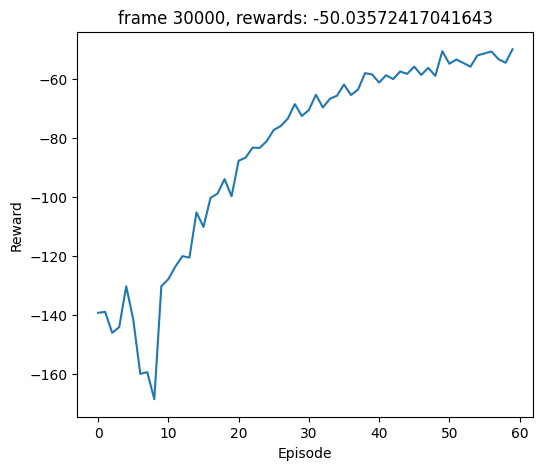

Training Progress: 100%|██████████| 30000/30000 [00:45<00:00, 657.15it/s, Test Reward=-50.04, Frame=3e+4] 


In [70]:
import tqdm

state = envs.reset()[0]
early_stop = False
max_frames = 30_000
frame_idx = 0
# Add progress bar for the main training loop
with tqdm.tqdm(total=max_frames, desc="Training Progress") as pbar:
    while frame_idx < max_frames and not early_stop:

        log_probs = []
        values = []
        states = []
        actions = []
        rewards = []
        masks = []
        entropy = 0

        # Add progress bar for the inner steps loop
        for step in tqdm.tqdm(range(num_steps), desc=f"Episode Steps", leave=False):
            state = torch.FloatTensor(state).to(device)
            dist, value = model(state)
            
            action = dist.sample()
            next_state, reward, done, truncated, info = envs.step(action.cpu().numpy())
            
            log_prob = dist.log_prob(action)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
            masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))

            states.append(state)
            actions.append(action)

            state = next_state
            frame_idx += 1

            # Update the main progress bar
            pbar.update(1)

            if frame_idx % 1000 == 0:
                test_reward = np.mean([test_env() for _ in range(10)])
                test_rewards.append(test_reward)
                plot(frame_idx, test_rewards)
                
                # Update progress bar description with current reward
                pbar.set_postfix({"Test Reward": f"{test_reward:.2f}", "Frame": frame_idx})
                
                if test_reward > threshold_reward:
                    early_stop = True
                    break
        
        next_state = torch.FloatTensor(next_state).to(device)
        _, next_value = model(next_state)
        returns = compute_gae(next_value, rewards, masks, values)

        returns = torch.cat(returns).detach()
        log_probs = torch.cat(log_probs).detach()
        values = torch.cat(values).detach()
        states = torch.cat(states)
        actions = torch.cat(actions)
        advantages = returns - values

        ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages)

        if early_stop:
            break

In [62]:
dist.sample()

tensor([[ 1.1655,  0.0530,  1.0082,  0.8855, -0.8628,  0.1434, -0.6040],
        [-0.1593,  1.0792, -0.1294,  0.1550,  1.4310,  0.0547,  1.1354],
        [ 1.6225,  0.5355, -0.1741, -0.6229, -0.0228,  0.0495, -0.4718],
        [ 0.4159,  1.3769,  1.1531,  0.3098, -1.3307,  0.0688,  0.4648],
        [ 0.5169,  1.2148,  0.2063,  0.4898, -0.2530,  1.0055, -0.5952],
        [ 2.8365,  1.4283,  0.6543, -0.3092, -0.3906,  0.2952, -0.1536],
        [ 0.8184,  1.6795, -0.5420, -0.6226,  0.5459,  1.0647,  0.8512],
        [ 0.4235, -0.1157,  1.2542,  0.3994,  0.9873, -0.5082,  0.2359],
        [ 2.2631,  1.3777,  1.4535,  0.2019,  0.7273,  0.4416,  0.2432],
        [-0.4186, -1.3647,  0.5963,  0.6024,  0.5289,  0.0595, -0.4104],
        [ 1.0065,  1.7198,  0.8242,  0.9375, -0.5926,  0.1449, -0.8905],
        [-0.1126, -1.6582,  1.4112, -0.2576,  0.4342,  0.9680, -1.3059],
        [ 0.5078,  0.6463, -0.0902,  0.6031,  0.5686,  0.8421,  0.0788],
        [-0.1124, -0.0106,  1.6714,  0.4490, -0.217

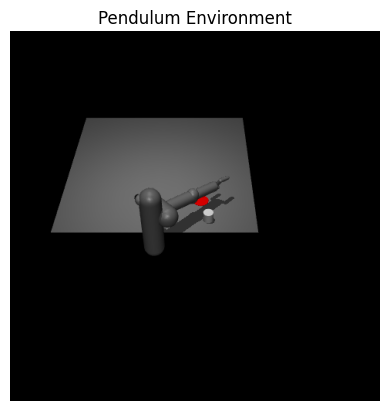

np.float64(-79.29449746773541)

In [63]:
test_env(vis=True)

In [19]:
next_state, reward, terminated, truncated, info

NameError: name 'terminated' is not defined

In [20]:
env.step(dist.sample().cpu().numpy()[0])

(array([0.9601185 , 0.2795935 , 0.07859165], dtype=float32),
 np.float64(-0.08491955429793277),
 False,
 True,
 {})

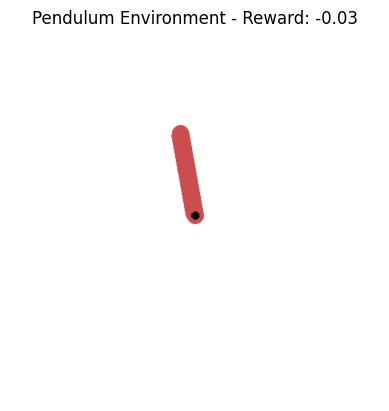

In [21]:

# Reset and get initial observation
obs, info = env.reset()
print("Observation space:", obs.shape)
print("Info:", info)

# Run a random episode and display it in real-time
done = False
start_time = time.time()

# Create figure once
plt.figure(figsize=(8, 6))

while time.time() - start_time < 10:  # Run for 10 seconds
    state = torch.FloatTensor(obs).unsqueeze(0).to(device)
    dist, _ = model(state)
    action = dist.sample().cpu().numpy()[0]
    obs, reward, done, truncated, info = env.step(action)
    
    # Get frame and display it
    frame = env.render()
    
    # Clear previous plot and show new frame
    clear_output(wait=True)
    plt.imshow(frame)
    plt.axis('off')
    plt.title(f'Pendulum Environment - Reward: {reward:.2f}')
    plt.show()
    
    # Reset if episode ends
    if done or truncated:
        obs, info = env.reset()
    
    time.sleep(0.05)  # Small delay to see the animation